In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from models import *
from train import *

In [2]:
def generate_points(grid_size, randomize=True):
    spacing = 1 / (grid_size - 1) * 2
    
    # Generate evenly spaced grid points
    x = np.linspace(-1 + spacing / 2, 1 - spacing / 2, grid_size)
    y = np.linspace(-1 + spacing / 2, 1 - spacing / 2, grid_size)
    grid_points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)

    # Generate perturbations
    if randomize:
        perturbations = np.random.uniform(-spacing/2, spacing/2, size=(grid_size**2, 2))
    else:
        perturbations = np.zeros(shape=(grid_size**2, 2))
    
    # Add perturbations to the grid points
    perturbed_points = grid_points + perturbations
    perturbed_points_tensor = torch.from_numpy(perturbed_points).float()   
    return perturbed_points_tensor

In [10]:
def encode_frequency(points_tensor, num_frequencies):
    points = points_tensor
    num_points = points.shape[0]
    
    # Expand points into frequency-based representation
    frequency_points = torch.zeros((num_points, 4 * num_frequencies))
    for i in range(num_frequencies):
        frequency = np.pi * 2**i / 2
        frequency_points[:, 4*i] = torch.cos(frequency * points[:, 0])
        frequency_points[:, 4*i+1] = torch.sin(frequency * points[:, 0])
        frequency_points[:, 4*i+2] = torch.cos(frequency * points[:, 1])
        frequency_points[:, 4*i+3] = torch.sin(frequency * points[:, 1])
    
    return frequency_points

In [4]:
def step_scheduler(optimizer, lr_rates, lr_epochs):
    def lr_lambda(epoch):
        idx = 0
        for i in range(len(lr_epochs)):
            if epoch >= lr_epochs[i]:
                idx = i
        return lr_rates[idx] / lr_rates[0]

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    return scheduler

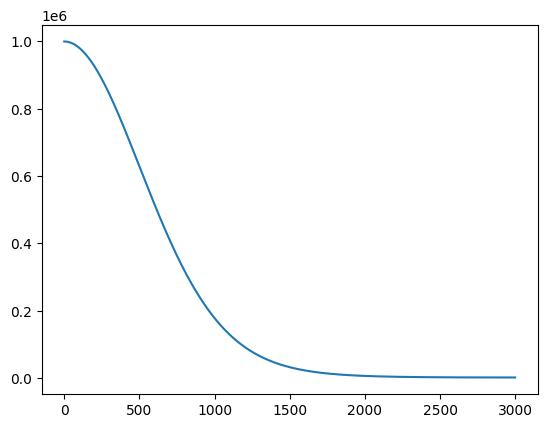

In [50]:
# testing out cosine power annealing shape
T_max = 3000
exponent_order = 1e3
epochs = np.arange(T_max) + 1
cos_proportions = (1 + np.cos(np.pi * epochs / T_max)) / 2
cos_power_proportions = np.power(exponent_order, cos_proportions + 1)

plt.plot(range(T_max), cos_power_proportions)
plt.show()

In [6]:
class CosinePowerAnnealingLR(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, exp_order=10.0, last_epoch=-1, verbose=False):
        self.T_max = T_max
        self.eta_min = eta_min
        self.exp_order = exp_order
        self.last_epoch = last_epoch
        self.verbose = verbose

        epochs = np.arange(T_max) + 1
        cos_proportions = (1 + np.cos(np.pi * epochs / T_max)) / 2

        # power curve applied to cosine values
        if exp_order < 1:
            raise ValueError('cosine_power_annealing() requires the "exponent order" parameter '
                             'to be greater than or equal to 1 but got ' + str(exp_order) + '.')
        elif exp_order == 1:
            self.cos_power_proportions = cos_proportions
        else:
            self.cos_power_proportions = np.power(exp_order, cos_proportions + 1)

        self.cos_power_proportions = self.cos_power_proportions - np.min(self.cos_power_proportions)
        self.cos_power_proportions = self.cos_power_proportions / np.max(self.cos_power_proportions)

        super(CosinePowerAnnealingLR, self).__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        if self.last_epoch >= self.T_max:
            return [self.eta_min for _ in self.base_lrs]

        return [(base_lr - self.eta_min) * self.cos_power_proportions[self.last_epoch] + self.eta_min
                for base_lr in self.base_lrs]

In [76]:
class CosineAnnealingWithLinearRestart(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0, last_epoch=-1, factor=0.5):
        self.T_0 = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.factor = factor
        self.last_restart = 0
        self.cycle = 0
        self.T_cur = T_0
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch == 0:
            return self.base_lrs
        elif (self.last_epoch - self.last_restart) == self.T_cur:
            self.last_restart = self.last_epoch
            self.cycle += 1
            self.T_cur = self.T_0 * (self.T_mult ** self.cycle)
            return [self.eta_min + (base_lr * (self.factor ** self.cycle) - self.eta_min) *
                    (1 + np.cos(np.pi / self.T_cur)) / 2
                    for base_lr in self.base_lrs]
        else:
            return [self.eta_min + (base_lr * (self.factor ** self.cycle) - self.eta_min) *
                    (1 + np.cos(np.pi * (self.last_epoch - self.last_restart) / self.T_cur)) / 2
                    for base_lr in self.base_lrs]

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

activations = {
    'ReLU GELU': [nn.ReLU(), nn.GELU()]
}

models = {}
loss_lists = {}

for activation_name, activation_fn in activations.items():
    enc_fn, dec_fn = activation_fn

    num_frequencies = 8
    position_encoder = lambda points: encode_frequency(points, num_frequencies)
    input_dim = num_frequencies * 4
    
    encoder = Encoder(input_dim, dims=256, blocks=4, layers=4, activation=enc_fn)
    decoder = Decoder(dims=128, blocks=4, layers=4, activation=dec_fn)
    model = Autoencoder(encoder, decoder, noise=0.0)
    
    grid_size = 32
    epochs = 50000

    encoder_opt = optim.Adam(model.encoder.parameters(), lr=0.001, betas=(0.9, 0.9))
    decoder_opt = optim.Adam(model.decoder.parameters(), lr=0.001, betas=(0.9, 0.9), weight_decay=0)

    # cos annealing schedulers
    cycles, T_0, T_mult = 2, 6000, 1
    cos_epochs = int(T_0 * (1 - T_mult ** (cycles)) / (1 - T_mult)) if T_mult != 1 else T_0 * cycles
    encoder_cos_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(encoder_opt, T_0=T_0, T_mult=T_mult, eta_min=0)
    decoder_cos_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(decoder_opt, T_0=T_0, T_mult=T_mult, eta_min=0)

    # linear schedulers
    encoder_lin_scheduler = optim.lr_scheduler.LinearLR(encoder_opt, 1.0, 0.0, epochs)
    decoder_lin_scheduler = optim.lr_scheduler.LinearLR(decoder_opt, 1.0, 0.0, epochs)

    # cos power annealing schedulers
    encoder_cos_p_scheduler = CosinePowerAnnealingLR(encoder_opt, T_max=epochs, eta_min=0, exp_order=10)
    decoder_cos_p_scheduler = CosinePowerAnnealingLR(decoder_opt, T_max=epochs, eta_min=0, exp_order=10)

    # cos linear annealing schedulers.............
    enc_cos_lin = CosineAnnealingWithLinearRestart(encoder_opt, T_0=T_0, T_mult=T_mult, eta_min=0, factor=0.3)
    de_cos_lin = CosineAnnealingWithLinearRestart(decoder_opt, T_0=T_0, T_mult=T_mult, eta_min=0, factor=0.3)

    encoder_scheduler = encoder_cos_p_scheduler
    decoder_scheduler = decoder_cos_p_scheduler
    
    print(f"Training with {activation_name} activation")
    #criterion = nn.SmoothL1Loss(beta=0.25)
    criterion = nn.MSELoss()
    model, lr_list, loss_list = train_autoencoder(model, epochs, criterion, generate_points, position_encoder, grid_size, 
                                                  encoder_opt, encoder_scheduler,
                                                  decoder_opt, decoder_scheduler, 
                                                  device)
    models[activation_name] = model
    loss_lists[activation_name] = loss_list

cuda
Training with ReLU GELU activation
Epoch [5000/50000], Loss: 0.02029
Epoch [10000/50000], Loss: 0.01688
Epoch [15000/50000], Loss: 0.01075
Epoch [20000/50000], Loss: 0.01033
Epoch [25000/50000], Loss: 0.01224
Epoch [30000/50000], Loss: 0.00864
Epoch [35000/50000], Loss: 0.00939
Epoch [40000/50000], Loss: 0.00769
Epoch [45000/50000], Loss: 0.00641
Epoch [50000/50000], Loss: 0.00681


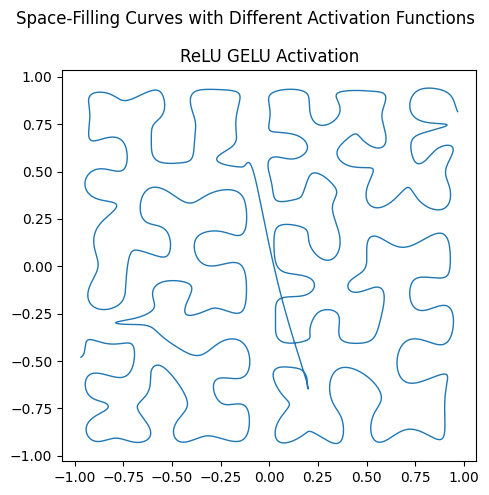

In [100]:
fig, axs = plt.subplots(1, len(activations), figsize=(5, 5))
if len(activations) == 1:
    axs = [axs]
    
fig.suptitle("Space-Filling Curves with Different Activation Functions")

def get_curve_points(model):
    grid = position_encoder(generate_points(32)).cuda()
    
    with torch.no_grad():
        z = model.norm(model.encoder(grid))
        min_val = z.min().item()
        max_val = z.max().item()
        num_points = int(1e4)
        z = torch.linspace(min_val, max_val, num_points).reshape(-1, 1).cuda()
        curve_points = model.decoder(z).cpu()
        
    return curve_points

for i, (activation_name, activation_fn) in enumerate(activations.items()):
    model = models[activation_name]
    model.eval()
    curve_points = get_curve_points(model)

    # Plot the space-filling curve
    axs[i].plot(curve_points[:, 0], curve_points[:, 1], linewidth=1, markersize=1)
    
    # uncomment these two if there's wacky offshoots way outside of the box
    #axs[i].set_xlim(-1, 1)
    #axs[i].set_ylim(-1, 1)
    axs[i].set_title(f"{activation_name} Activation")

plt.tight_layout()
plt.show()

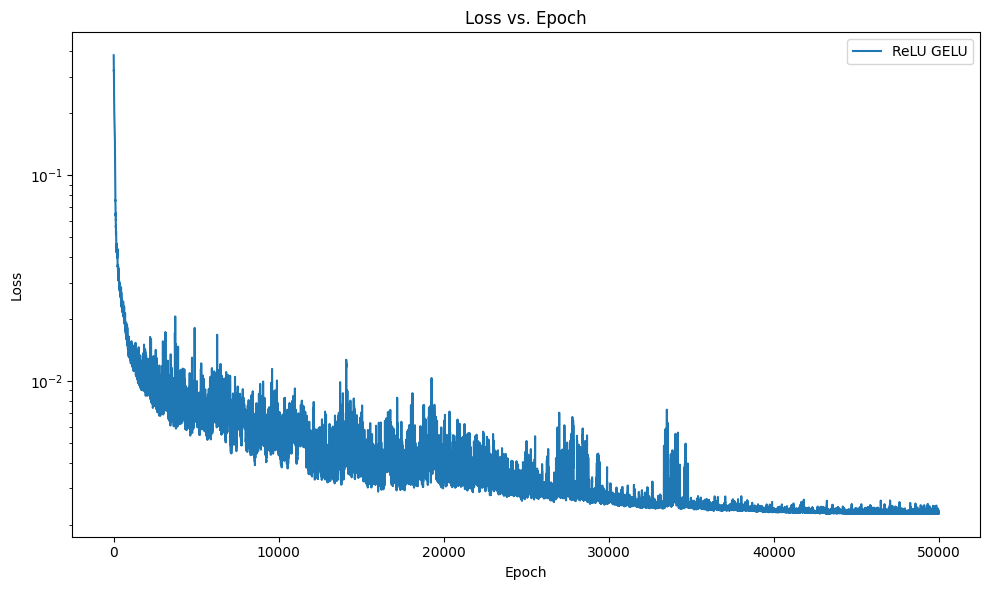

In [101]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_yscale('log')
for activation_name, loss_list in loss_lists.items():
    ax.plot(range(1, len(loss_list) + 1), loss_list, label=activation_name)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs. Epoch")
ax.legend()

plt.tight_layout()
plt.show()

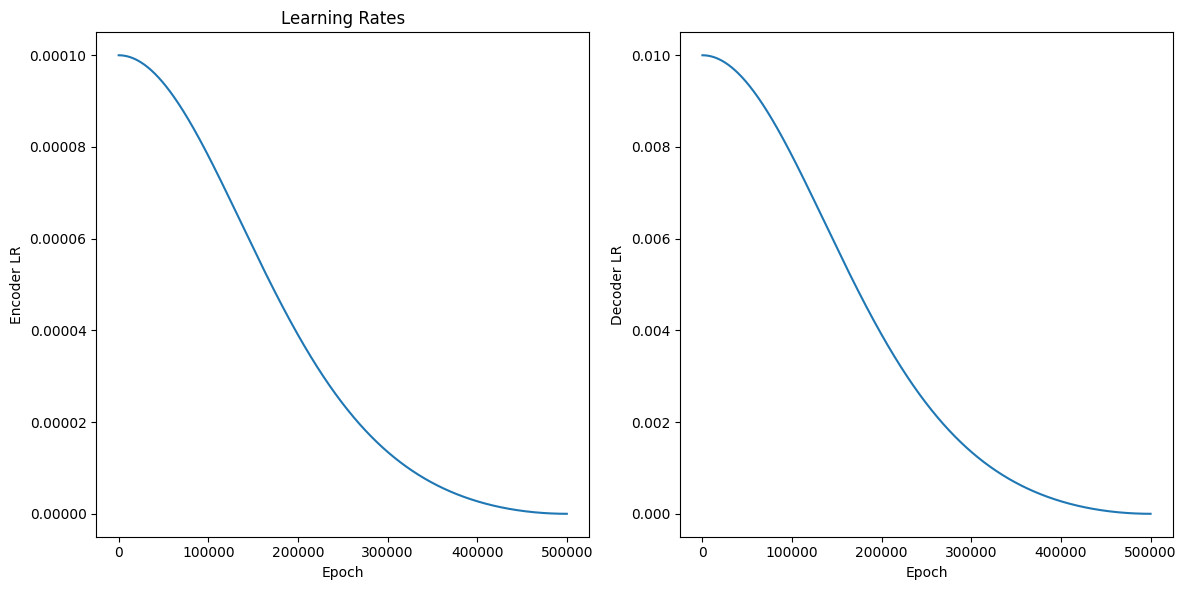

In [97]:
lr_encoder, lr_decoder = zip(*lr_list)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(0, len(lr_encoder)), lr_encoder)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Encoder LR")
ax1.set_title("Learning Rates")

ax2.plot(range(0, len(lr_decoder)), lr_decoder)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Decoder LR")

plt.tight_layout()
plt.show()